## Generate plant binary and instance masks

#### Detect background via k-means
#### Filter out non-plant objects
#### If multiple specimens, try to split using connectedcomponents

In [1]:
import os
import time
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'white'

In [2]:
COLORS = np.array(
    [
        0.000, 0.447, 0.741,
        0.850, 0.325, 0.098,
        0.929, 0.694, 0.125,
        0.494, 0.184, 0.556,
        0.466, 0.674, 0.188,
        0.301, 0.745, 0.933,
        0.635, 0.078, 0.184,
        0.300, 0.300, 0.300,
        0.600, 0.600, 0.600,
        1.000, 0.000, 0.000,
        1.000, 0.500, 0.000,
        0.749, 0.749, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 1.000,
        0.667, 0.000, 1.000,
        0.333, 0.333, 0.000,
        0.333, 0.667, 0.000,
        0.333, 1.000, 0.000,
        0.667, 0.333, 0.000,
        0.667, 0.667, 0.000,
        0.667, 1.000, 0.000,
        1.000, 0.333, 0.000,
        1.000, 0.667, 0.000,
        1.000, 1.000, 0.000,
        0.000, 0.333, 0.500,
        0.000, 0.667, 0.500,
        0.000, 1.000, 0.500,
        0.333, 0.000, 0.500,
        0.333, 0.333, 0.500,
        0.333, 0.667, 0.500,
        0.333, 1.000, 0.500,
        0.667, 0.000, 0.500,
        0.667, 0.333, 0.500,
        0.667, 0.667, 0.500,
        0.667, 1.000, 0.500,
        1.000, 0.000, 0.500,
        1.000, 0.333, 0.500,
        1.000, 0.667, 0.500,
        1.000, 1.000, 0.500,
        0.000, 0.333, 1.000,
        0.000, 0.667, 1.000,
        0.000, 1.000, 1.000,
        0.333, 0.000, 1.000,
        0.333, 0.333, 1.000,
        0.333, 0.667, 1.000,
        0.333, 1.000, 1.000,
        0.667, 0.000, 1.000,
        0.667, 0.333, 1.000,
        0.667, 0.667, 1.000,
        0.667, 1.000, 1.000,
        1.000, 0.000, 1.000,
        1.000, 0.333, 1.000,
        1.000, 0.667, 1.000,
        0.333, 0.000, 0.000,
        0.500, 0.000, 0.000,
        0.667, 0.000, 0.000,
        0.833, 0.000, 0.000,
        1.000, 0.000, 0.000,
        0.000, 0.167, 0.000,
        0.000, 0.333, 0.000,
        0.000, 0.500, 0.000,
        0.000, 0.667, 0.000,
        0.000, 0.833, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 0.167,
        0.000, 0.000, 0.333,
        0.000, 0.000, 0.500,
        0.000, 0.000, 0.667,
        0.000, 0.000, 0.833,
        0.000, 0.000, 1.000,
        0.000, 0.000, 0.000,
        0.143, 0.143, 0.143,
        0.857, 0.857, 0.857,
        1.000, 1.000, 1.000
    ]
).astype(np.float32).reshape(-1, 3)

COLORS = np.round(COLORS*256).astype(np.uint8)
COLORS = COLORS[:,::-1]

In [3]:
def bin_img(img, bins=32):
    delta = 256 / bins
    img = np.clip(np.round(img/delta)*delta,0,255).astype(np.uint8)
    return img

def kmeans(img,K,convert_to_LAB=True,iters=1000):
    
    if convert_to_LAB:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
   
    # apply k-means using the specified number of clusters and
    # then create the quantized image based on the predictions
    Z = img.reshape((-1,3))
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iters, 1.0)
    ret, label, center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res = res.reshape((img.shape))
    res = cv2.cvtColor(res, cv2.COLOR_LAB2BGR)
    
    return res


def show(img):
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

## Algo

1. Bin the image, followed by meanshift and perform kmeans to detect background color
2. Get background color mask, take the largest blob, fill it, this way we ignore the borders surrounding the sheet
3. Then, we get foreground mask by inverting the background mask and doing AND with the filled bg mask
4. Next, we dilate the foreground mask and get all objects via connected components (CCs)
5. Now we need to filter out the non-plant objects
   1. Filter the CC on a minimum pixel amount and area to ignore noise
   2. Filter the CC on overlap with borders
   3. Filter the CC if its area is similar to the area of its rectangular boundinx box
   4. Cut out non-dilated object, save separately and add to merged mask

6. Save merged mask for binary segmentation, save each plant instance separately for instance segmentation


### Change data_dir to root directory, put herbarium images in 'img' folder

You can try using high resolution images, probably gices better results but will take more time to run

Below was executed on the 1024 height images

In [4]:
data_dir = 'datasets/sample'
img_dir = os.path.join(data_dir, 'img')

mask_dir = os.path.join(data_dir,'plant_masks')
# dirs for multiple plants
split_mask_dir = os.path.join(data_dir,'plant_masks_split')
out_split_dir = os.path.join(data_dir,'outputs_split')

dirs = [mask_dir, split_mask_dir, out_split_dir]
for d in dirs:
    os.makedirs(d,exist_ok=True)

Starting specimen mask extraction for 19 images
109601.jpg
Meanshift done in 0.77 s
Performed kmeans with k=3 in 1.99 s


C:\Users\kenzo\AppData\Local\Temp\ipykernel_18844\1444166152.py:98: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


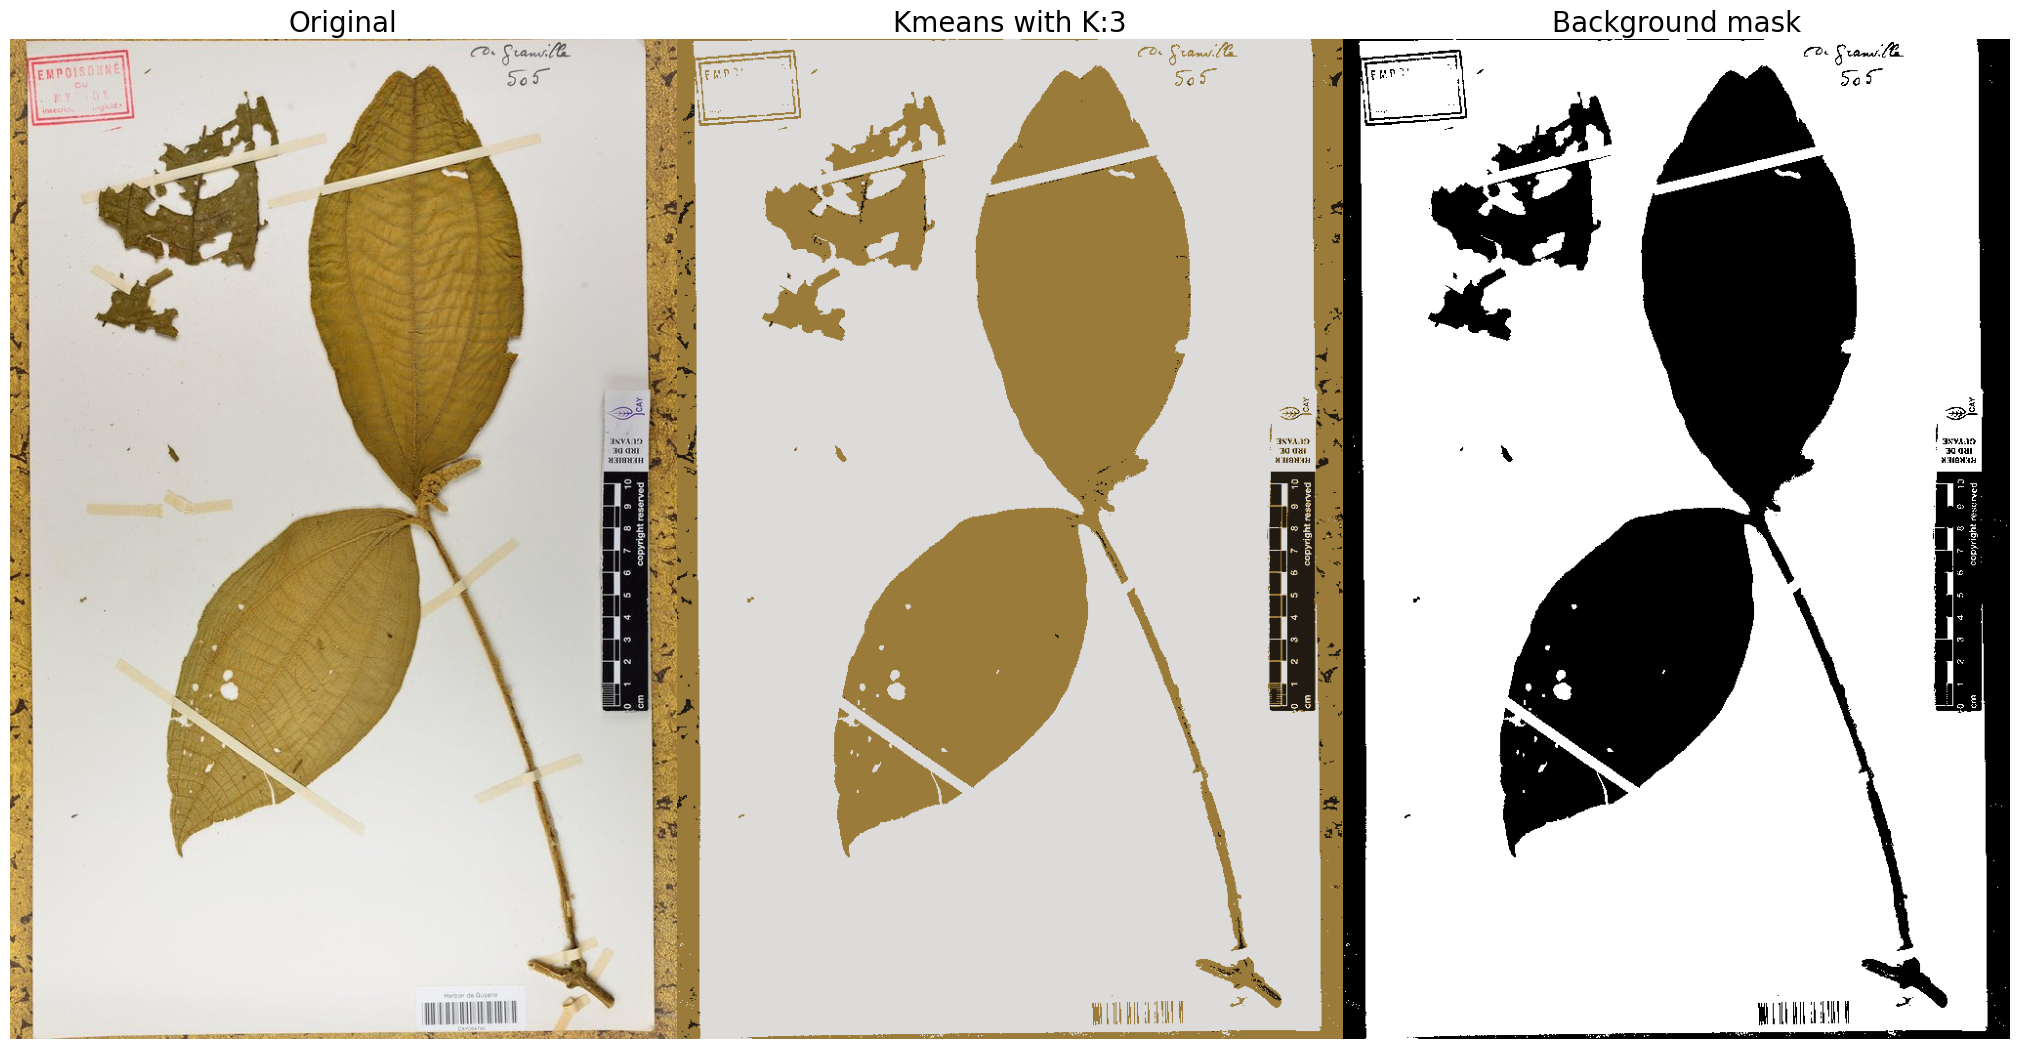

C:\Users\kenzo\AppData\Local\Temp\ipykernel_18844\1444166152.py:163: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Kernel size: 11


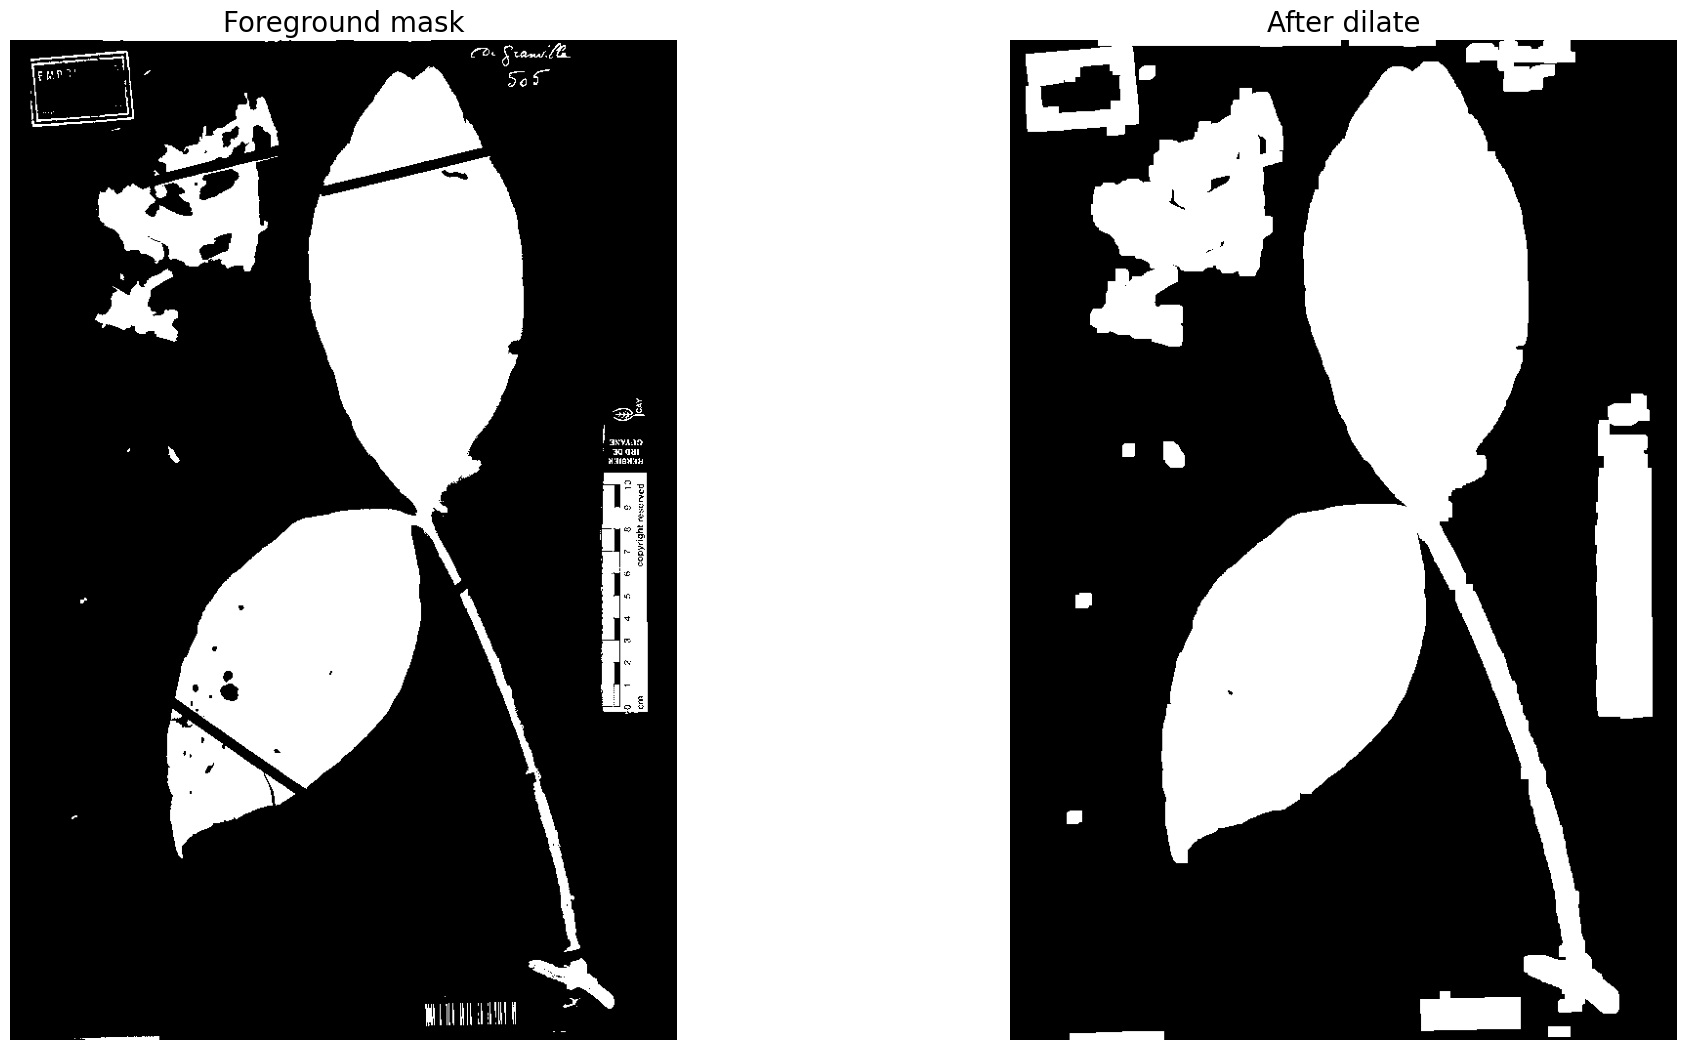

C:\Users\kenzo\AppData\Local\Temp\ipykernel_18844\1444166152.py:297: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


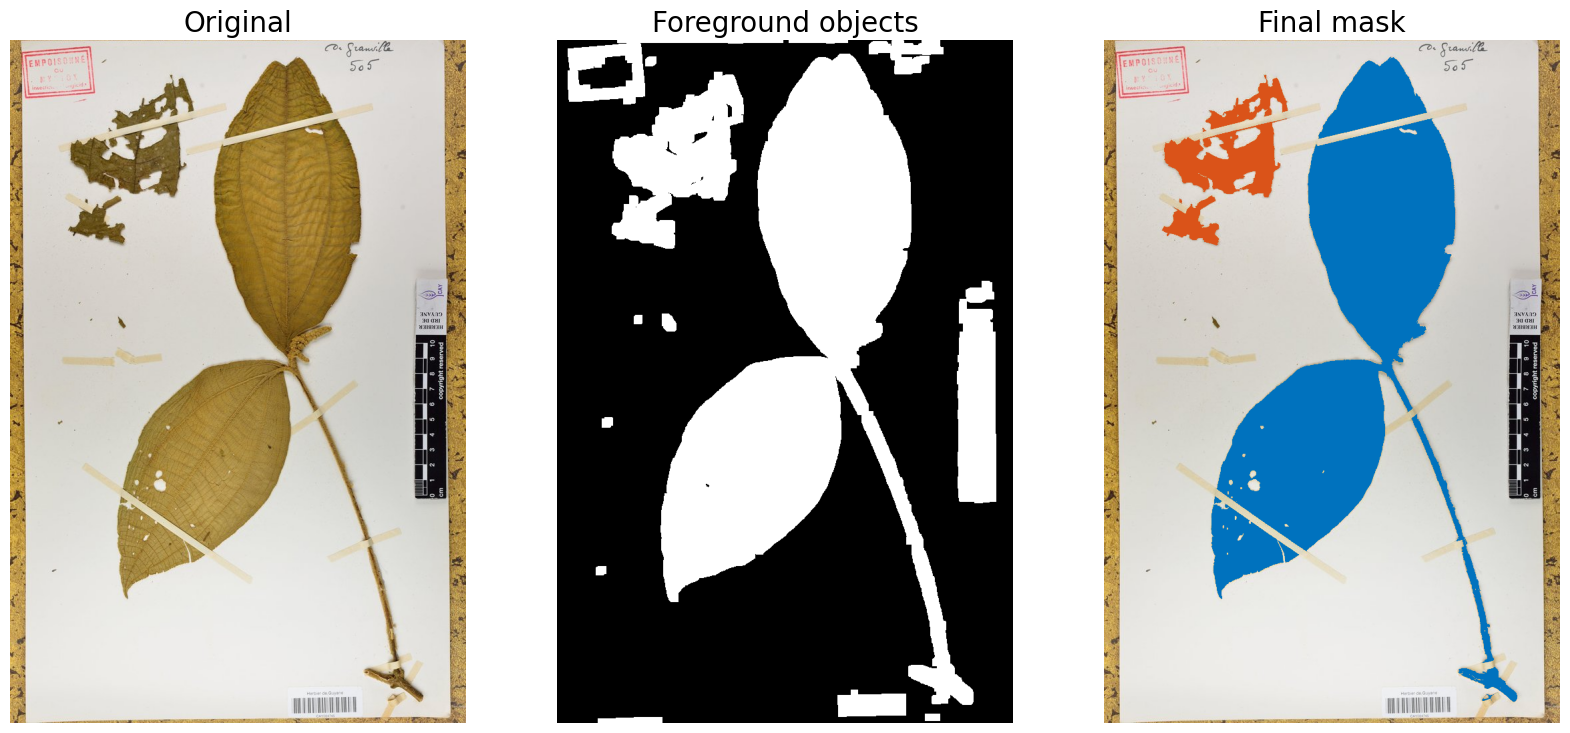

BM000521755.jpg
Meanshift done in 0.72 s
Performed kmeans with k=3 in 1.2 s


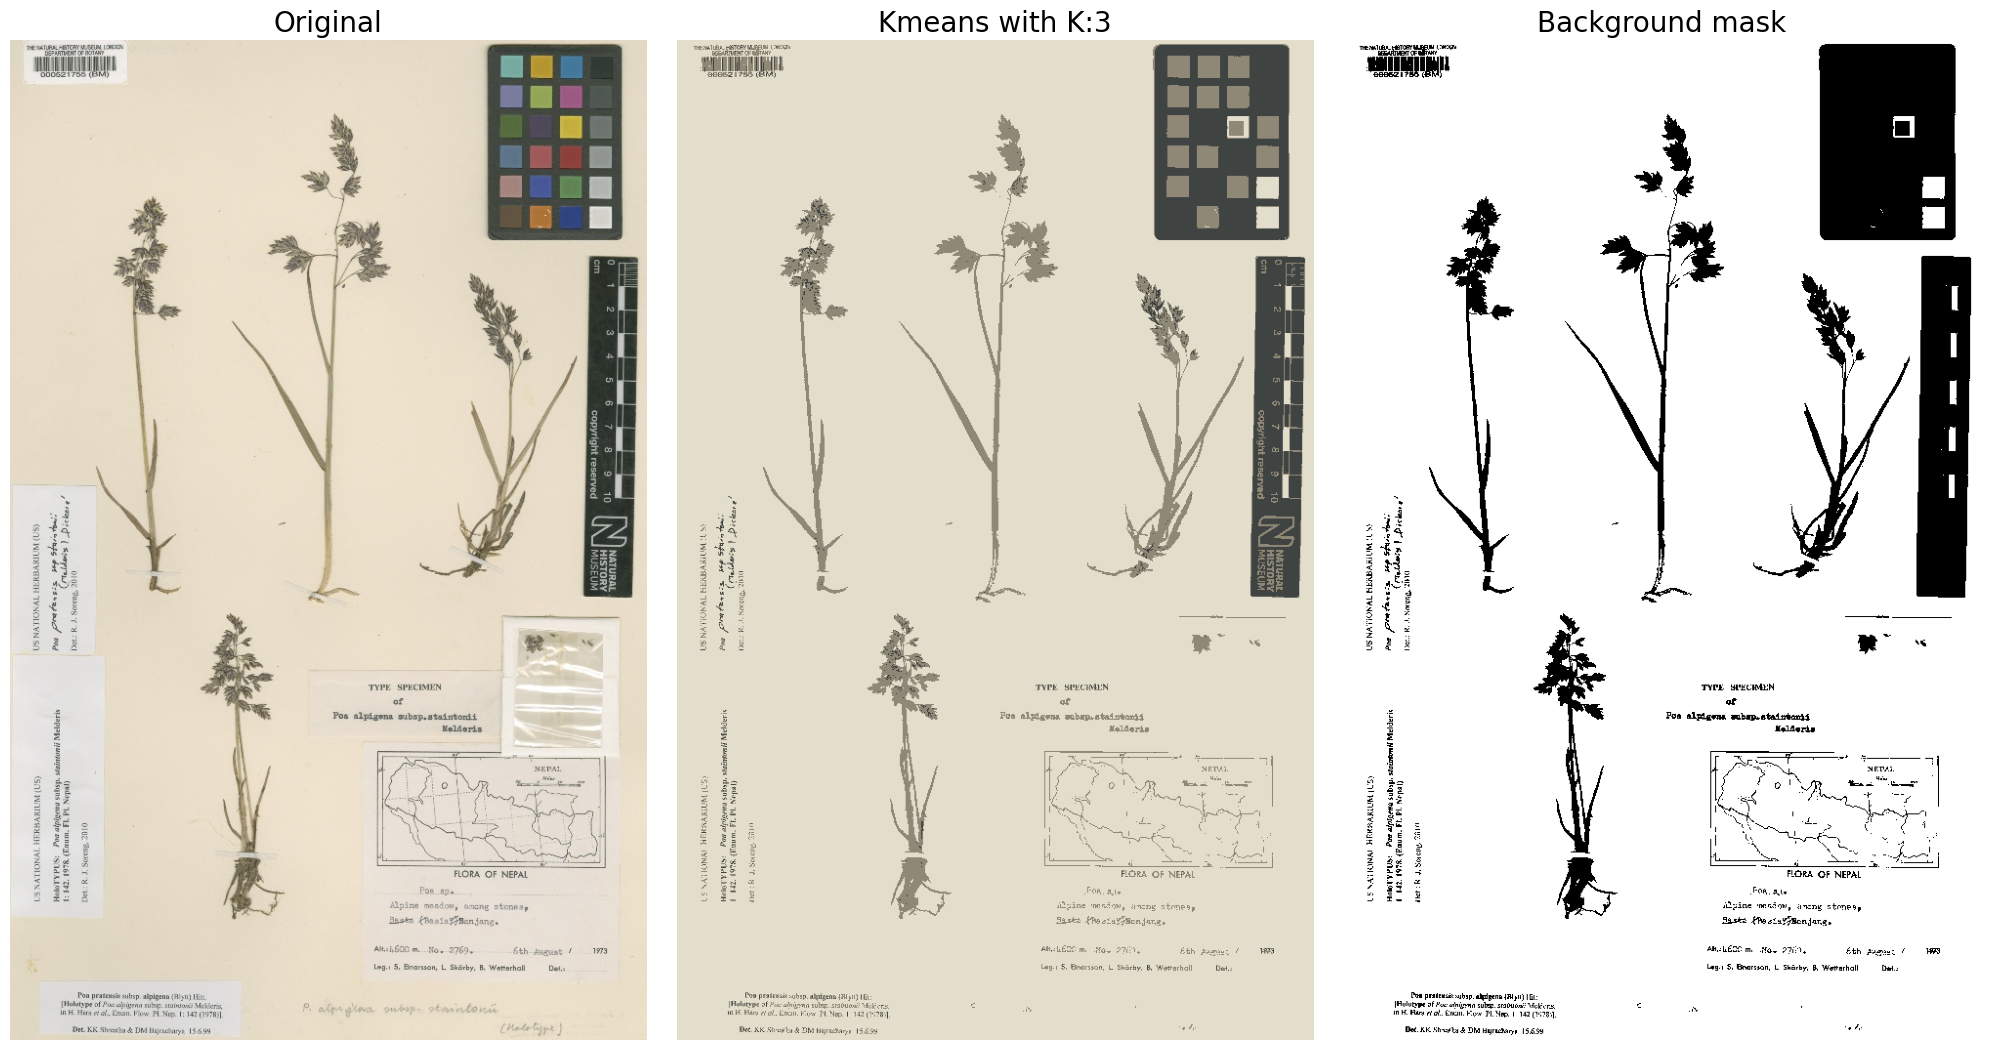

Kernel size: 11


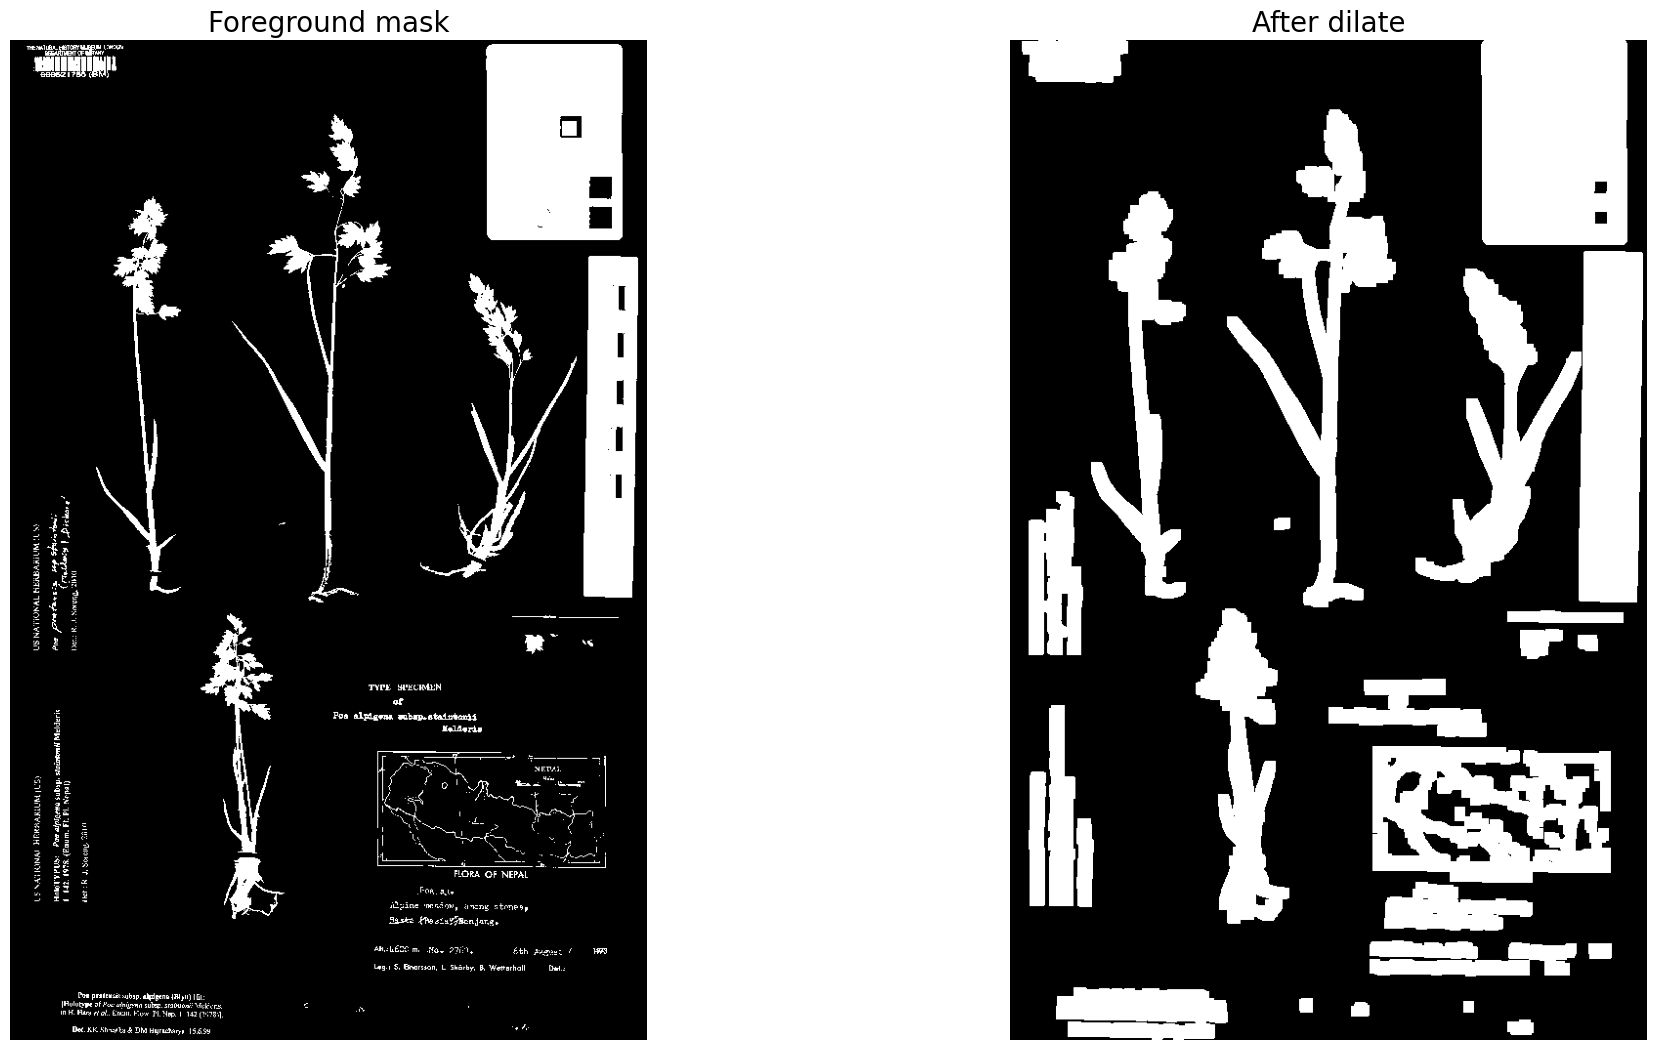

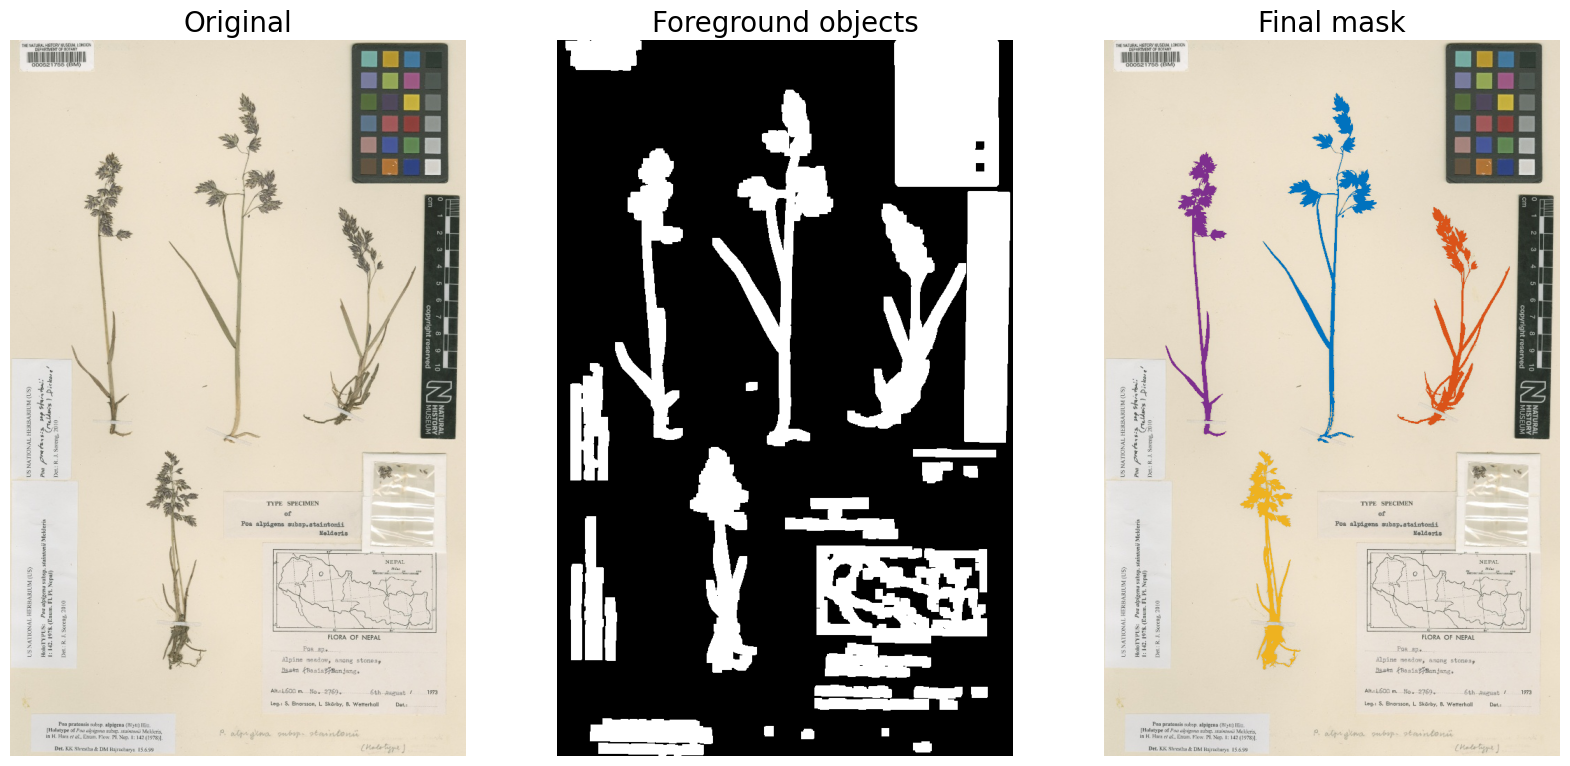


Finished: 2 images, 4.93 s/img


In [8]:
count = 0
k = 3

# Save the outputs
save = True
# Show outputs and print results
# set verbose to 2 to show more info
verbose = 1
# Set to true to rerun on processed images
skip_existing = False

# resize images by this factor
# can be useful for large resolution to speed it up
resize = 1
errors = {}

img_filenames = [f for f in sorted(os.listdir(img_dir))]
print(f'Starting specimen mask extraction for {len(img_filenames)} images')

print_frequency = max(len(img_filenames) // 10, 5)
times = []

img_filenames = ['109601.jpg','BM000521755.jpg']
for img_fname in img_filenames:
    
    count += 1
    
    extension = img_fname.rsplit('.',1)[-1]
    if extension.lower() != 'jpg':
        img_fname_jpg = img_fname.replace(f'.{extension}','.jpg')
    else:
        img_fname_jpg = img_fname    
    mask_path = os.path.join(mask_dir, img_fname.replace(f'.{extension}','.png'))
    output_path = os.path.join(out_split_dir, img_fname_jpg)
    
    if skip_existing and os.path.exists(mask_path):
        if verbose:
            print(f'Found mask for {img_fname}, skipping')
        continue
    
    t_start = time.time()
    
    if count % print_frequency == 0:
        avg_time = round(np.mean(times),2)
        print(f'Done: {count} / {len(img_filenames)}, {avg_time} s/img')
    
    
    img_path = os.path.join(img_dir,img_fname)
    img = cv2.imread(img_path)
    # skip if cant read image
    if img is None:
        print('Problem reading image:', img_path)
        errors[img_fname] = 'Problem reading image'
        continue
    
    orig_img = img.copy()
    if resize > 1:
        img = cv2.resize(img, None, fx=1/resize,fy=1/resize)
    img_h, img_w = img.shape[:2]
    
    # Convert to LAB colorspace
    img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)

    # Bin image and do meanshift    
    img = bin_img(img, bins=32)
    t1 = time.time()
    # sp = spatial window
    sp = 10
    # sr = color window
    sr = 15
    img = cv2.pyrMeanShiftFiltering(img,sp=sp,sr=sr)
    if verbose:
        print(img_fname)
        print(f'Meanshift done in {round(time.time()-t1,2)} s')
    # Do k-means with k=3 (you can try other values too)
    img_k = kmeans(img, k, convert_to_LAB=False)
    if verbose:
        print(f'Performed kmeans with k={k} in {round(time.time()-t1,2)} s')
   
    # Get most occurring color => assign as bg color
    colors,counts = np.unique(img_k.reshape(-1, img_k.shape[-1]), axis=0,return_counts=True)
    max_color_idx = np.argmax(counts)
    bg_color = colors[max_color_idx]
    # Get mask of bg color
    bg_mask_orig = (img_k==bg_color).all(-1).astype(np.uint8)
    
    # Find the largest background component.
    # Note: range() starts from 1 since 0 is the background label.
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(bg_mask_orig, connectivity=4)
    max_label, max_size = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)], key=lambda x: x[1])
    biggest_cc_mask = (output == max_label).astype(np.uint8)
    
    if verbose:
        plt.figure(figsize=(20,10))
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.subplot(1,3,1)
        show(orig_img)
        plt.title('Original', fontsize=20)
        plt.axis('off')

        plt.subplot(1,3,2)
        show(img_k)
        plt.title(f'Kmeans with K:{k}', fontsize=20)
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(bg_mask_orig, cmap='gray')
        plt.title('Background mask', fontsize=20)
        plt.axis('off')
        plt.show()
    
    # Now need to fill it
    # Because plant may overlap with edge
    # take bbox of background and fill that
    contours, hierarchy = cv2.findContours(biggest_cc_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    cnt = contours[max_index]
    
    bg_mask_filled = biggest_cc_mask.copy()
    kernel_size = round(max(img_w,img_h)/100 + 1)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    cv2.drawContours(bg_mask_filled,[cv2.convexHull(cnt)],0,255,-1)
    bg_mask_filled = cv2.erode(bg_mask_filled,kernel)
    
    # Ignore object mask if less than 30K pixels
    color_mask_thresh = 30000
    # Check the 30 largest components
    components_to_check = 30
    
    # Make a mask for the border of the image
    # We take outer 10% as the border
    border_percent = 0.10
    border_h = int(img_h * border_percent)
    border_w = int(img_w * border_percent)
    
    border_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    border_mask[:border_h] = 255
    border_mask[-border_h:] = 255
    border_mask[:,:border_w] = 255
    border_mask[:,-border_w:] = 255
    
    
    # Take non-background, perform AND with filled background
    # this removes the borders surrounding the sheet
    mask = cv2.bitwise_not(bg_mask_orig*255)
    mask = cv2.bitwise_and(mask, bg_mask_filled)

    # Merge close together parts of the mask
    # first big dilate
    mask_dilate = cv2.dilate(mask,kernel)
    
    if verbose:
        res = orig_img.copy()
        res[~(mask_dilate.astype(bool))] = [180,105,255]

        plt.figure(figsize=(20,10))
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.subplot(1,2,1)
        print('Kernel size:',kernel_size)
        plt.imshow(mask, cmap='gray')
        plt.title('Foreground mask',fontsize=20)
        plt.axis('off')
    
        plt.subplot(1,2,2)
        plt.imshow(mask_dilate,cmap='gray')
        plt.title('After dilate', fontsize=20)
        plt.axis('off')
        plt.show()

    # Now need to determine if 1 or multiple plants based on the 
    # areas and shape CCs
    # take largest CC from mask
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask_dilate, connectivity=4)
    sorted_by_area = np.argsort(-stats[:, cv2.CC_STAT_AREA])
    

    # Black mask to join all instances
    final_plant_mask = np.zeros(mask.shape, dtype=np.uint8)
    # Output image
    out_img = orig_img.copy()
    color_index = 0
    instance_masks = []

    # If foreground overlaps this much with border, we skip it
    border_overlap_thresh = 0.6
    # Plant needs to be at least 15% of page width or height, else skip
    min_size_ratio = 0.15
    total_pixels = img_w*img_h
    # CC object needs to be at least .5 % of page pixels, else we stop iteration
    min_cc_area = total_pixels*0.005
    # CC object is skipped if its shape is similar to its bounding box (rectangle)
    rect_ratio_thresh = 0.75

    # Component with index 0 is the background
    for i in range(1,min(components_to_check+1,nb_components)):
        i = sorted_by_area[i]
        area = stats[i, cv2.CC_STAT_AREA]
        
        # Stop iteration early when the objects are too small
        if area < min_cc_area:
            if verbose == 2:
                print('area too small, break')
            break
        
        object_mask = (output == i).astype(np.uint8)

        # Overlap with border
        border_overlap_mask = cv2.bitwise_and(border_mask, object_mask)
        border_overlap = cv2.countNonZero(border_overlap_mask) / area 

        # Check if rectangular shape
        pts = cv2.findNonZero(object_mask)
        rect = cv2.minAreaRect(pts)
        x_c,y_c,rect_w,rect_h = cv2.boundingRect(pts)
        box = np.intp(cv2.boxPoints(rect))
        rect_area = cv2.contourArea(box)
        rect_ratio = area/rect_area
            
        # Cut with original mask (non-dilated)
        object_mask = cv2.bitwise_and(object_mask, mask)
        
        if verbose == 2:
            print('Rect ratio:',round(rect_ratio,3))
            print('Border overlap:',round(border_overlap,3))
            print('Ratios of w/h',round(rect_w/img_w,3),round(rect_h/img_h,3))
            
            plt.imshow(object_mask, cmap='gray')
            plt.title('connectedcomponent mask '+str(i)+' '+str(area))
            plt.show()
        
        # Filtering of the CCs
        # Too much overlap with border => skip
        if border_overlap >= border_overlap_thresh:
            if verbose == 2:
                print('Border overlap skip')
            continue
        # Object widht or height too small => skip
        if max(rect_w/img_w, rect_h/img_h) < min_size_ratio:
            if verbose == 2:
                print('Min size skip')
            continue
        # Object area too similar to area of its bounding box => skip
        if rect_ratio >= rect_ratio_thresh:
            if verbose == 2:
                print('Rect ratio skip')
            continue
        # Cut object too small => skip
        if cv2.countNonZero(object_mask) < min_cc_area:
            if verbose == 2:
                print('Area skip')
            continue
        
        # Object passed all checks, likely a plant
        # Add to final mask
        final_plant_mask = cv2.bitwise_or(final_plant_mask, object_mask)
        # Color output image with unique color (to label quickly later)
        out_img[object_mask.astype(bool)] = COLORS[color_index]
        
        # Save instance masks separately
        instance_masks.append(object_mask*255)
        color_index += 1

    final_plant_mask*=255
    # Resize plant masks back to original size if necessary
    if resize > 1:
        h,w = orig_img.shape[:2]
        hires_mask = np.clip(cv2.resize(final_plant_mask, (w,h)), 0,255)
        _, hires_mask = cv2.threshold(hires_mask,127,255,cv2.THRESH_BINARY)

        for i in range(len(instance_masks)):
            hires_ins_mask = np.clip(cv2.resize(instance_masks[i], (w,h)), 0,255)
            _, hires_ins_mask = cv2.threshold(hires_ins_mask,127,255,cv2.THRESH_BINARY)
            instance_masks[i] = hires_ins_mask

    else:
        hires_mask = final_plant_mask
    
    # Save the masks
    if save:
        cv2.imwrite(mask_path, hires_mask)
        cv2.imwrite(output_path, out_img)
        img_name = img_fname_jpg.replace('.jpg','')
        for i in range(len(instance_masks)):
            fname_mask = f'{img_name}_plant_{i}.png'
            ins_mask_path = os.path.join(split_mask_dir, fname_mask)
            cv2.imwrite(ins_mask_path, instance_masks[i])
    
    # Show the outputs
    if verbose:
        plt.figure(figsize=(20,10))
        plt.margins(0,0)
        plt.subplot(1,3,1)
        show(orig_img)
        plt.title('Original', fontsize=20)
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask_dilate,cmap='gray')
        plt.title('Foreground objects', fontsize=20)
        plt.axis('off')

        plt.subplot(1,3,3)
        show(out_img)
        plt.title('Final mask', fontsize=20)
        plt.axis('off')
        plt.show()

    
    time_taken = time.time() - t_start
    times.append(time_taken)


avg_time = round(np.mean(times),2)
print(f'\nFinished: {count} images, {avg_time} s/img')
errors_path = os.path.join(data_dir, 'plant_extraction_errors.json')

if len(errors):
    with open(errors_path,'r') as f:
        json.dump(errors, f)